In [90]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import yaml 
import os 

from flour.data import FlourDataset
from flour.models import *

In [91]:
filename = "../data/test.csv"
config_file = "../configs/lr_flour_z_3_standard_cv.yaml"

In [92]:
# load the config file
with open(config_file) as f:
    config = yaml.safe_load(f)
# define the options
do_regression = config["regression"] if "regression" in config else False
checkpoint_dir = os.path.join("..", config["output_path"])

Load dataset and models

In [93]:
# Load the dataset
data = FlourDataset(
    filename,
    remove_empty_columns=True,
    impute_missing_values=True,
    impute_negative_values=True,
    scaler=config["scaling_method"],
)
if os.path.exists(os.path.join(checkpoint_dir, "scaler.pkl")):
    data.load_scaler(os.path.join(checkpoint_dir, "scaler.pkl"))
    print("Scaler loaded")
# Load the model
model_name = config["model_name"]
model_params = config["hyperparameters"]
model = eval(f"{model_name}(**model_params)")
model.load(os.path.join(checkpoint_dir, "model.pkl"))
print(model.hyperparameters())


Scaler loaded
{}


Get predictions

In [94]:
# Do the predictions
X_test, y_test = data.prepare_data(
    remove_columns=["Package ID", "Production Mill", "Color"],
    one_hot_columns=["Production Recipe"],
    regression=do_regression,
)
y_pred = model.predict(X_test)

Classification report

In [95]:
# Save the evaluation metrics
desired_order = ["Low", "Average", "High"]
if do_regression:
    y_test = data.convert_to_categorical(y_test)
    y_pred = data.convert_to_categorical(y_pred)

In [96]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Average       0.81      0.91      0.86       176
        High       0.00      0.00      0.00         4
         Low       0.84      0.70      0.76       116

    accuracy                           0.82       296
   macro avg       0.55      0.54      0.54       296
weighted avg       0.81      0.82      0.81       296



/Users/rplebret/Documents/job_candidatures/SDSC - Senior Data Scientist 032024/flour/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rplebret/Documents/job_candidatures/SDSC - Senior Data Scientist 032024/flour/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rplebret/Documents/job_candidatures/SDSC - Senior Data Scientist 032024/flour/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defi

Confusion matrix

Text(70.72222222222221, 0.5, 'True Label')

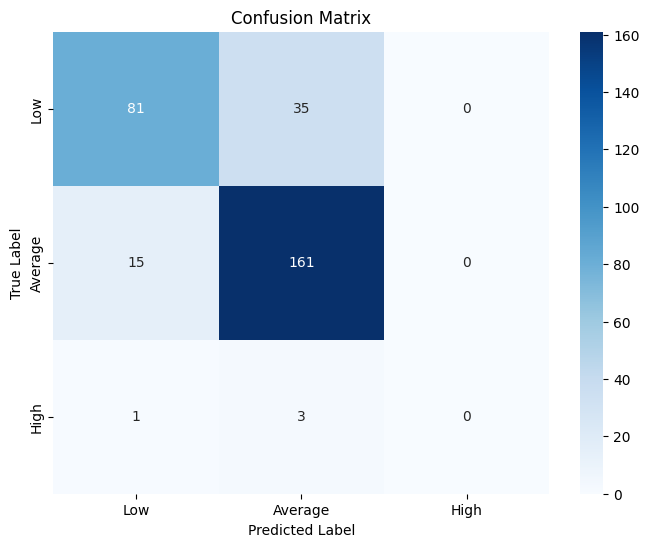

In [97]:
# Save the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=desired_order)

## Create a heatmap visualization
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size as needed
ax = sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=desired_order,
    yticklabels=desired_order,
    ax=ax,
)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

## Cost analysis

In [120]:
cost=[[1.2, 2.5, 5], [1.2, 2.5, 5], [1.2, 2.5, 5]]
refund = [[0, -1.3, -3.8], [0, 0, -2.5], [0, 0, 0]]
loss = [[0, 0, 0], [-1.3, 0, 0], [-3.8, -2.5, 0]]
frequency = [[0.39, 0.59, 0.02]]

Expected profit with ML model

In [111]:
profit_matrix = (cm / sum(cm)) * frequency * 1000 *cost
print(profit_matrix)

[[ 390.80412371  259.42211055           nan]
 [  72.37113402 1193.34170854           nan]
 [   4.82474227   22.2361809            nan]]


/var/folders/3z/nvbljry53s5_wp97nncv_7sh0000gp/T/ipykernel_1534/3513228240.py:1: RuntimeWarning: invalid value encountered in divide
  profit_matrix = (cm / sum(cm)) * frequency * 1000 *cost


In [112]:
refund_matrix = (cm / sum(cm)) * frequency * 1000 * refund
print(refund_matrix)

[[   0.         -134.89949749           nan]
 [   0.            0.                   nan]
 [   0.            0.                   nan]]


/var/folders/3z/nvbljry53s5_wp97nncv_7sh0000gp/T/ipykernel_1534/265641000.py:1: RuntimeWarning: invalid value encountered in divide
  refund_matrix = (cm / sum(cm)) * frequency * 1000 * refund


In [122]:
loss_matrix = (cm / sum(cm)) * frequency * 1000 * loss
print(loss_matrix)

[[  0.           0.                  nan]
 [-78.40206186   0.                  nan]
 [-15.27835052 -22.2361809           nan]]


/var/folders/3z/nvbljry53s5_wp97nncv_7sh0000gp/T/ipykernel_1534/4101990973.py:1: RuntimeWarning: invalid value encountered in divide
  loss_matrix = (cm / sum(cm)) * frequency * 1000 * loss


In [100]:
# Assuming your array is called 'arr'
def remove_nan_columns(arr):
    # Identify columns with all NaN values
    cols_to_remove = np.isnan(arr).all(axis=0)
    # Return a copy of the array excluding those columns
    return arr[:, ~cols_to_remove]

In [123]:
profit_matrix = remove_nan_columns(profit_matrix)
refund_matrix = remove_nan_columns(refund_matrix)
loss_matrix = remove_nan_columns(loss_matrix)

Perfect prediction

In [102]:
ground_truth = np.array([[0.39, 0, 0], [0, 0.59, 0], [0, 0, 0.02]])
perfect_prediction = ((ground_truth * 1000) * cost).sum()

Expected Profit Matrix with refunds

In [117]:
profit_matrix + refund_matrix

array([[ 390.80412371,  124.52261307],
       [  72.37113402, 1193.34170854],
       [   4.82474227,   22.2361809 ]])

In [128]:
fixed_cost = 1000
human_cost = 500
print(f"Revenue with ML: {profit_matrix.sum()}")
print(f"Loss with ML: {loss_matrix.sum()}")
print(f"Refunds with ML: {refund_matrix.sum()}")
print(f"Profit with ML: {(profit_matrix + refund_matrix).sum()-fixed_cost}")
print(f"Profit with perfect prediction: {perfect_prediction-fixed_cost-human_cost}")
print(f"ML cost: {(loss_matrix+refund_matrix).sum()}")

Revenue with ML: 1942.9999999999998
Loss with ML: -115.91659327565662
Refunds with ML: -134.8994974874372
Profit with ML: 808.1005025125626
Profit with perfect prediction: 543.0
ML cost: -250.81609076309383
